# 使用raw_rnn实现自定义的decoding功能

In [1]:
import helpers
import tensorflow as tf

from tensorflow.contrib.rnn import BasicLSTMCell, LSTMStateTuple

In [2]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

#### Encoder部分，使用双向encoder 
来自上一部分代码演示

In [3]:
PAD = 0
EOS = 1

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_units = 2 * encoder_hidden_units # bidirectional RNN, 见后面的解释


with tf.name_scope('minibatch'):
    encoder_inputs = tf.placeholder(
        shape=(None, None), dtype=tf.int32, name='encoder_inputs')
    encoder_inputs_length = tf.placeholder(
        shape=(None,), dtype=tf.int32, name='encoder_inputs_length')

    decoder_targets = tf.placeholder(
        shape=(None, None), dtype=tf.int32, name='decoder_targets')

with tf.name_scope('embedding'):
    embeddings = tf.Variable(
        tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0),
        dtype=tf.float32)

encoder_inputs_embedded = tf.nn.embedding_lookup(
    embeddings, encoder_inputs)

encoder_cell = BasicLSTMCell(encoder_hidden_units)

# 双向dynamic_rnn
((encoder_fw_outputs, encoder_bw_outputs),
 (encoder_fw_final_state, encoder_bw_final_state)) = (
    tf.nn.bidirectional_dynamic_rnn(
        cell_fw=encoder_cell,
        cell_bw=encoder_cell,
        inputs=encoder_inputs_embedded,
        sequence_length=encoder_inputs_length,
        dtype=tf.float32, time_major=True)
)

# 将正向和反向的encoder的final state拼接到一起，需要对state.c和state.h分别操作
encoder_final_state_c = tf.concat(
    (encoder_fw_final_state.c, encoder_bw_final_state.c), 1)

encoder_final_state_h = tf.concat(
    (encoder_fw_final_state.h, encoder_bw_final_state.h), 1)

encoder_final_state = LSTMStateTuple(
    c=encoder_final_state_c,
    h=encoder_final_state_h
)

# 使用raw_rnn实现自定义的decoding功能:

## 不提供真实的句子作为`decoder_input`

## Decoder via `tf.nn.raw_rnn`

**`dynamic_rnn`**需要提供decoder_input
1. 提供真实的sequence作为decoder_input，与testing环境相差太大
2. 提供`[<pad>, <pad>, ... <pad>]`作为decoder_input，浪费input信息



![seq2seq-feed-previous](figure/nct-seq2seq.png)
* **这个图片的操作在训练和测试阶段都可以使用**
* 图片来自 http://www.wildml.com/2016/04/deep-learning-for-chatbots-part-1-introduction/*

In [4]:
decoder_cell = BasicLSTMCell(decoder_hidden_units)

**`encoder_max_time`**和**`batch_size`**这两个Tensor取决于placeholder输入的数据的维度。注意代码里面的placeholder的形状是**`None`**

In [5]:
encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))

## 定义`decoder_lengths`，作为decoder输出sequence的预期长度的上限

## 实际的decoding结果的长度取决于`<eos>`出现的位置

### 1. 如果`<eos>`出现的位置早于达到长度上限，则之后的decoding cell 输出的内容忽略不计
### 2. 如果达到decoding 长度上限以后`<eos>`没有出现，则强行停止decoding


```
loop_fn_initial()

while current_length[i] <= max_decoding_length[i] for some i:

    (previous_output, previous_state) = loop_fn_transition ( previous_output, previous_state)
    
     current_length[i] += 1 for every i

```
    
    

In [6]:
decoder_lengths = encoder_inputs_length + 3
# 这里定义每一个样本的decoding的输出序列的上限比这个样本encoder输入序列的长度大一些
# 例如，
# encoder_inputs_length = [2, 3, 5, 4]
# decoder_length = [5, 6, 8, 7]

In [7]:
assert EOS == 1 and PAD == 0

eos_time_slice = tf.ones([batch_size], dtype=tf.int32, name='EOS')
pad_time_slice = tf.zeros([batch_size], dtype=tf.int32, name='PAD')

eos_step_embedded = tf.nn.embedding_lookup(embeddings, eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings, pad_time_slice)

In [8]:
# 用于从当前RNN output预测最可能的单词
W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size], -1, 1), dtype=tf.float32)
b = tf.Variable(tf.zeros([vocab_size]), dtype=tf.float32)

In [9]:
def loop_fn_initial():
    initial_elements_finished = (0 >= decoder_lengths)  # all False at the initial step
    initial_input = eos_step_embedded
    initial_cell_state = encoder_final_state
    initial_cell_output = None
    initial_loop_state = None  # we don't need to pass any additional information
    
    return (initial_elements_finished,
            initial_input,
            initial_cell_state,
            initial_cell_output,
            initial_loop_state)

![alt text](figure/loop_fn.png)

In [10]:
def loop_fn_transition(time, previous_output, previous_state, previous_loop_state):

    def get_next_input():
        """产生下一个时间的输入单词
        
        根据当前时间的rnn output,对minibatch中的每一个样本预测这个时间最可能的单词，
        将其作为下一个时间的decoding任务的输入单词
        """
        output_logits = tf.add(tf.matmul(previous_output, W), b) # [batch_size, vocabSize]
        prediction = tf.argmax(output_logits, axis=1) # [batch_size]
        next_input = tf.nn.embedding_lookup(embeddings, prediction) # [batch_size, embed_dim]
        return next_input
    
    elements_finished = (time >= decoder_lengths)
    # boolen tensor of [batch_size], 决定是否每一个样本都完成了decoding任务
    # 对batch_size中的每一个，如果time大于预期的decoding_length，则该样本的decoding任务已经完成

    finished = tf.reduce_all(elements_finished)
    # 当且尽当所有的 elements_finished 元素都是 True,即，所有样本都已经完成decoding时，finished = True
    
    input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)
    # return pad_step_embedded if finished=True,
    #   lambda: pad_step_embedded, batch_size个[pad] 的 embedding
    #   lambda的用初始将tensor pad_step_embedded转化成一个函数，满足tf.cond()的 Arg 要求
    # return get_next_input if finished=False
    #   get_next_input 用来产生下一个时间的input单词的embedding
    
    state = previous_state
    output = previous_output
    loop_state = None

    return (elements_finished, 
            input,
            state,
            output,
            loop_state)

In [11]:
def loop_fn(time, previous_output, previous_state, previous_loop_state):
    if previous_state is None:    # time == 0
        assert previous_output is None and previous_state is None
        return loop_fn_initial()
    else:
        return loop_fn_transition(time, previous_output, previous_state, previous_loop_state)

## 使用raw_rnn()实现自定义rnn

In [12]:
decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

In [13]:
print(decoder_outputs_ta)
print(decoder_outputs)

Tensor("TensorArrayStack/TensorArrayGatherV3:0", shape=(?, ?, 40), dtype=float32)


RNN decoding的输出 `decoder_outputs` ，维度[max_time, batch_size, hidden_units]的Tensor，使用下面的参数W, b映射为维度为 [max_time, batch_size, vocab_size]的`decoder_logits` 其中`vocab_size`是固定数值的超参数，`max_time`, `batch_size`有feed给tf的数据决定.

In [14]:
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(
    tf.shape(decoder_outputs))
decoder_outputs_flat = tf.reshape(
    decoder_outputs, (-1, decoder_dim))
decoder_logits_flat = tf.add(
    tf.matmul(decoder_outputs_flat, W), b)
decoder_logits = tf.reshape(
    decoder_logits_flat, 
    (decoder_max_steps, decoder_batch_size, vocab_size))

decoder_prediction = tf.argmax(decoder_logits, 2)

In [15]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [16]:
sess.run(tf.global_variables_initializer())

In [17]:
batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[3, 8, 4, 2, 3, 8, 6, 6]
[3, 9, 8, 3, 5, 4, 6, 8]
[2, 3, 6, 7, 7]
[6, 6, 2, 3, 6, 3, 6, 2]
[9, 6, 9]
[3, 5, 7]
[7, 2, 7, 5, 9, 7, 3]
[7, 4, 3, 4, 2, 4]
[8, 7, 3]
[3, 5, 2, 9, 5]


In [18]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, encoder_input_lengths_ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] + [PAD] * 2 for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
    }

In [19]:
loss_track = []

In [20]:
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.367949962615967
  sample 1:
    input     > [5 4 4 9 6 0 0 0]
    predicted > [2 2 2 2 2 2 2 2 0 0 0]
  sample 2:
    input     > [3 8 4 7 5 0 0 0]
    predicted > [2 2 2 2 9 2 2 2 0 0 0]
  sample 3:
    input     > [3 9 3 7 0 0 0 0]
    predicted > [2 2 9 2 9 2 2 0 0 0 0]

batch 1000
  minibatch loss: 0.5663590431213379
  sample 1:
    input     > [4 7 2 5 0 0 0 0]
    predicted > [4 7 2 5 1 0 0 0 0 0 0]
  sample 2:
    input     > [4 7 8 5 0 0 0 0]
    predicted > [4 7 8 5 1 0 0 0 0 0 0]
  sample 3:
    input     > [7 8 3 6 5 6 8 6]
    predicted > [7 8 3 6 6 6 6 6 1 0 0]

batch 2000
  minibatch loss: 0.2570143938064575
  sample 1:
    input     > [6 9 2 0 0 0 0 0]
    predicted > [6 9 2 1 0 0 0 0 0 0 0]
  sample 2:
    input     > [2 6 9 0 0 0 0 0]
    predicted > [2 6 9 1 0 0 0 0 0 0 0]
  sample 3:
    input     > [4 7 4 3 9 6 7 0]
    predicted > [4 7 4 3 6 6 7 1 0 0 0]

batch 3000
  minibatch loss: 0.11511566489934921
  sample 1:
    input     > [4 6 8

loss 0.1144 after 300100 examples (batch_size=100)


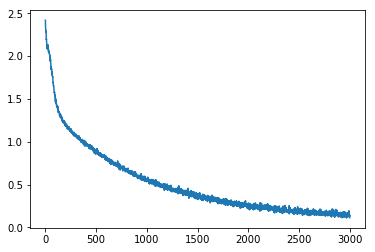

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))